In [1]:
import matplotlib.pyplot as plt

In [2]:
from glob import glob
import numpy as np 
from sklearn.decomposition import PCA
import cv2

import torch
import torch.nn as nn
from torch.utils import data

import torch.multiprocessing as mp
from thomas_detector import ThomasDetector, get_piece_mask
from puzzle_grid import PuzzleGrid, get_xy_min

from vision import *
import imgaug as ia
import imgaug.augmenters as iaa


Using cache found in C:\Users\Thomas/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [3]:

def get_img_lists():
    img_groups = [glob(f'../vision/train_imgs/g{i} *') for i in range(1, 5)]
    img_lists = []
    for img_group in img_groups:

        detector = ThomasDetector()

        img = cv2.cvtColor(cv2.imread(img_group[0])[:, 160:], cv2.COLOR_BGR2RGB) 
        detector.process(img.copy())
        pieces_list = [p for p in detector.pieces if p.is_valid()]

        img_list = [[] for i in range(len(pieces_list))]

        for img_path in img_group:
            img = cv2.cvtColor(cv2.imread(img_path)[:, 160:], cv2.COLOR_BGR2RGB) 
            detector.process(img.copy())

            for i, piece in enumerate(pieces_list):
                img_list[i].append(piece.natural_img * (piece.img.reshape(piece.img.shape[0], piece.img.shape[1], 1) > 128))
            
#             for i, piece in enumerate(pieces_list):
#                 img_list[i].append(piece.natural_img)

        img_lists.append(img_list)

        
    return img_lists

img_lists = get_img_lists()
imgs = []
for img_list1 in img_lists:
    for img_list in img_list1:
        for img in img_list:
            if (len(imgs) == 0 or (img is not imgs[-1])):
                imgs.append(img)

In [4]:
matcher = VisionMatcher('C:/Code/CS134/HW1/done_exploded_colored2.jpg')

In [5]:
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)),
#     iaa.Sometimes(
#         0.5,
#         iaa.GaussianBlur(sigma=(0, 0.5))
#     ),
#     iaa.LinearContrast((0.75, 1.5)),
#     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-4, 4)
    )
], random_order=True) # apply augmenters in random order

images_augs = [seq(images=imgs[:]) for i in range(4)]

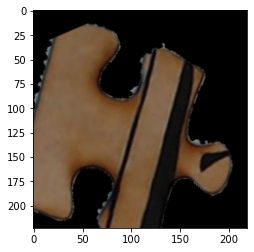

In [6]:
plt.imshow(images_augs[0][1])

In [7]:
def calc_iou(img1, img2, image_size = 124):
    img1 = cv2.resize(img1, (image_size, image_size))
    mask1 = cv2.dilate((img1.mean(axis = 2) > 0).astype(np.uint8), None, iterations=1)
    img2 = cv2.resize(img2, (image_size, image_size))
    mask2 = cv2.dilate((img2.mean(axis = 2) > 0).astype(np.uint8), None, iterations=1)
    
#     plt.imshow(img1)
#     plt.show()
    
#     plt.imshow(mask1)
#     plt.show()
    
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(mask2)
#     plt.show()
    
    return (mask1 * mask2).sum() / (mask1.sum() + mask2.sum())

In [8]:
from tqdm import tqdm


xs = []
ys = []
n_iters = 3

for i in tqdm(range(len(images_augs[0][:]))):
    for j in range(len(images_augs)):
        for iters in range(n_iters):
            k = np.random.choice([0, 1, 2, 3])
            k_init = np.random.choice([0, 1, 2, 3])
            base_img = np.rot90(images_augs[j][i], k = k_init)
            rot_img = np.rot90(images_augs[np.random.randint(0, len(images_augs))][i], k = k)

            ys.append(k == k_init)
            xs.append(list(abs(run_model(base_img)[0] - run_model(rot_img)[0])) + [calc_iou(base_img, rot_img)])

100%|████████████████████████████████████████████████████████████████████████████████| 405/405 [09:02<00:00,  1.34s/it]


In [9]:
len(ys)

4860

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
model = LogisticRegression().fit(xs, ys)

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
((model.predict_proba(xs)[:, 1] > 0.5) == ys).mean()

0.8271604938271605

In [17]:
model.coef_

array([[-4.43217370e-01, -3.54750184e-01,  4.32681003e-01,
        -3.07911142e-01,  2.83969383e-01, -3.53036316e-02,
        -6.41144918e-02,  5.16931090e-01,  3.66014299e-01,
        -4.22591484e-01, -3.93110993e-01,  2.37920661e-01,
        -4.17186199e-01, -4.11802206e-01, -2.81450882e-01,
         3.18158545e-02, -3.58844663e-01, -1.26828741e-01,
         4.29413520e-01, -2.70645472e-01,  2.16801927e-01,
         2.81460348e-01,  4.33267136e-02,  6.71886904e-02,
         6.04577451e-02,  4.94528650e-01,  1.22271409e-01,
        -6.45076117e-02,  2.28669824e-01, -1.05729420e-01,
         2.21131768e-01,  6.15391202e-01, -5.05119214e-01,
         1.07801955e-01, -2.27598969e-01,  5.21326773e-01,
         3.63420751e-01,  3.39573054e-01, -3.33682962e-01,
         5.90158252e-01, -4.54257697e-01,  3.30287664e-01,
        -4.98947508e-01, -2.10115437e-01, -4.38218778e-01,
         3.64251116e-01,  3.02243432e-01, -3.24815586e-01,
         3.05396391e-01,  8.01906134e-02,  2.05631266e-0

In [18]:
model.intercept_

array([-0.08146978])